In [1]:
%load_ext autoreload
%autoreload 2
import bnl
from bnl import fio, mtr, viz

In [2]:
# Now. I want to find and set up the new metric and reason through it on some of these examples
refs, ests = fio.salami_annos(776)

## Now how do my I define recall between ref_rated_boundaries and est_rated_boundaries?

1) I take all the boundary keys in the ref_rated boundaries, 
2) see how much est_rated_boundary can recover: hit rate, and count inversions of pair ranks.

So we only need to look at all the potential boundaries in ref_rated_boundaries.

In [12]:
import mir_eval, librosa
import numpy as np
from scipy import stats
from collections import Counter

In [382]:
# Let's do match-event first, and get the indicator vector of whether each ref bs of any depth is recalled at all:
def salience_at_ref_bs(ref_bs, ref_sal, est_bs, est_sal, window=0.5):
    hits = mir_eval.util.match_events(ref_bs, est_bs, window=window)
    est_sal_at_ref_bs = np.zeros(len(ref_bs))
    for ref_index, est_index in hits:
        # if it's a hit, get the salience of that boundary in est_sal
        est_sal_at_ref_bs[ref_index] = est_sal[est_index] + 1
    # print(est_sal_at_ref_bs)
    return ref_sal, est_sal_at_ref_bs

def b_rank_recall(ref_sal, est_sal_at_ref_bs):
    # Now we have two lists, let's just count inversions in ranking
    inversions, total_pairs = mir_eval.hierarchy._compare_frame_rankings(
        ref_sal, est_sal_at_ref_bs, transitive=True
    )
    hit_recalled = np.count_nonzero(est_sal_at_ref_bs)
    bs_to_hit = len(ref_sal)
    hit_recall = hit_recalled / bs_to_hit if bs_to_hit > 0 else 1.0
    print(f"\t hit:  {hit_recall:.4f}, {hit_recalled:.0f}, {bs_to_hit:.0f}")

    rank_recalled = (total_pairs - inversions) 
    rank_to_recall = total_pairs
    rank_recall = rank_recalled / rank_to_recall if rank_to_recall > 0 else 1.0
    
    print(f"\t rank: {rank_recall:.4f}, {rank_recalled:.0f}, {rank_to_recall:.0f}")
    
    return mir_eval.util.f_measure(rank_recall, hit_recall, beta=1.0)

def bmeasure(ref_itvls, est_itvls, window=0.5, beta=1.0, force_mono=False):
    # Get the salience
    ref_bs, ref_sal = boundary_salience(ref_itvls, force_mono=False)
    est_bs, est_sal = boundary_salience(est_itvls, force_mono=force_mono)
    
    # Get the scores
    ref_sal, est_sal_at_ref_bs = salience_at_ref_bs(ref_bs, ref_sal, est_bs, est_sal, window=window)
    est_sal, ref_sal_at_est_bs = salience_at_ref_bs(est_bs, est_sal, ref_bs, ref_sal, window=window)

    print('  computing recall...')
    recall = b_rank_recall(ref_sal, est_sal_at_ref_bs)
    print('  compuing precision...')
    precision = b_rank_recall(est_sal, ref_sal_at_est_bs)
    f_measure = mir_eval.util.f_measure(recall, precision, beta=beta)
    return precision, recall, f_measure


def boundary_salience(hier_itvls, force_mono=False):
    hier = bnl.H(hier_itvls)
    # cast to mono accordingly
    if force_mono and not hier.has_mono_B():
        if force_mono == 'naive':
            hier = hier.force_mono_B(min_seg_dur=1)
        elif force_mono == 'bsc':
            hier = hier.decode_B(sr=10, bw=1)

    hier.plot()
    # use counter to accumulate boundary counts, which in the monotonic case will be salience
    counter = Counter()
    for lvl in hier.levels:
        counter.update(lvl.beta)
    boundaries, salience = zip(*sorted(counter.items()))
    return np.array(boundaries), np.array(salience)


## Look at flat against flat:

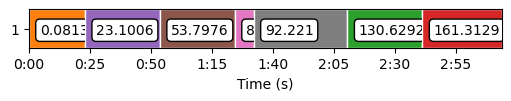

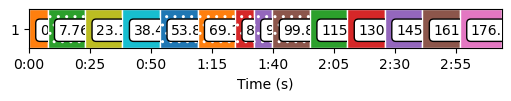

In [383]:
ref_bs, ref_sal = boundary_salience([flat_ref.itvls])
est_bs, est_sal = boundary_salience([flat_est.itvls])

hit rate: (0.5294117647058824, 1.0, 0.6923076923076924)
  computing recall...
	 hit:  1.0000, 9, 9
	 rank: 1.0000, 0, 0
  compuing precision...
	 hit:  0.5294, 9, 17
	 rank: 1.0000, 0, 0
bmeasure: (0.6923076923076924, 1.0, 0.8181818181818182)


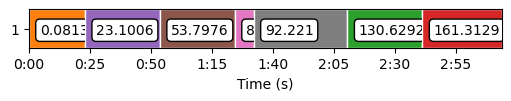

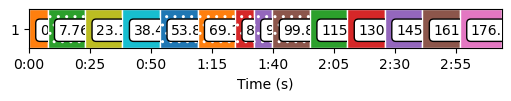

In [384]:
flat_ref = ref1.levels[0]
flat_est = ref2.levels[0]
window=0.5

print('hit rate:', mir_eval.segment.detection(flat_ref.itvls, flat_est.itvls, window=window))
print('bmeasure:', bmeasure([flat_ref.itvls], [flat_est.itvls], window=window))

  computing recall...
	 hit:  1.0000, 27, 27
	 rank: 0.6111, 99, 162
  compuing precision...
	 hit:  0.5094, 27, 53
	 rank: 0.8154, 499, 612


(0.6270740732121663, 0.7586206896551725, 0.6866033972744899)

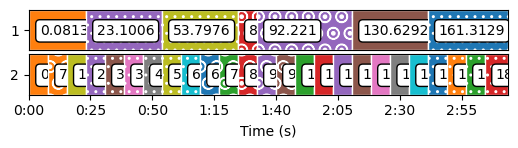

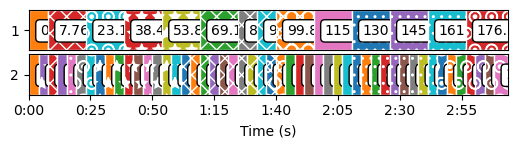

In [385]:
bmeasure(ref1.itvls, ref2.itvls)

  computing recall...
	 hit:  0.2264, 12, 53
	 rank: 0.6454, 395, 612
  compuing precision...
	 hit:  0.6000, 12, 20
	 rank: 0.4767, 82, 172
	 0.5313	0.3352	0.4111


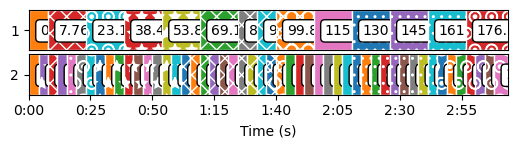

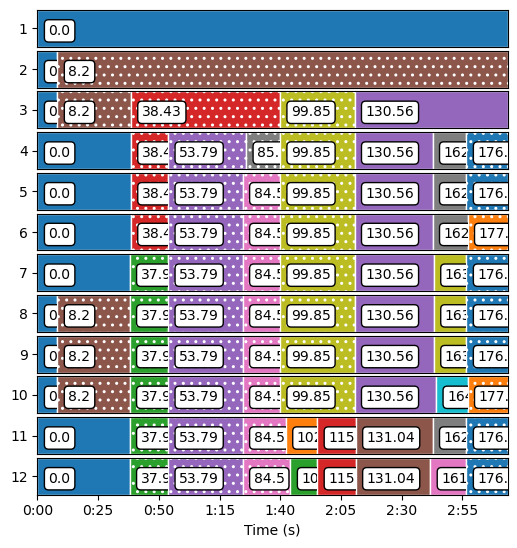

In [386]:
b = bmeasure(refs['6'].itvls, ests['mu5_gamma5'].itvls, window=0.5, beta=1.0)
print('\t', '\t'.join([f'{i:.4f}' for i in b]))

  computing recall...
	 hit:  0.2075, 11, 53
	 rank: 0.5882, 360, 612
  compuing precision...
	 hit:  0.7333, 11, 15
	 rank: 0.4255, 40, 94
	 0.5386	0.3068	0.3909


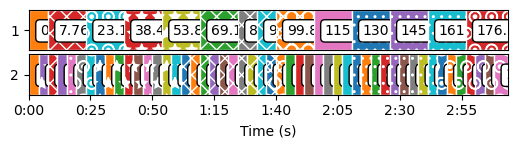

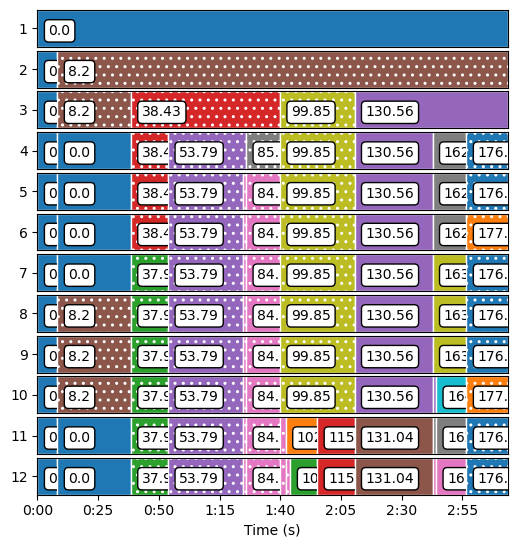

In [387]:
b = bmeasure(refs['6'].itvls, ests['mu5_gamma5'].itvls, window=0.5, beta=1.0, force_mono='naive')
print('\t', '\t'.join([f'{i:.4f}' for i in b]))


  computing recall...
	 hit:  0.1887, 10, 53
	 rank: 0.5882, 360, 612
  compuing precision...
	 hit:  0.9091, 10, 11
	 rank: 0.1731, 9, 52
      p, r, f: 0.2908	0.2857	0.2882


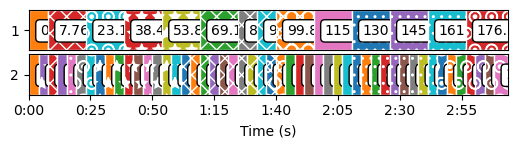

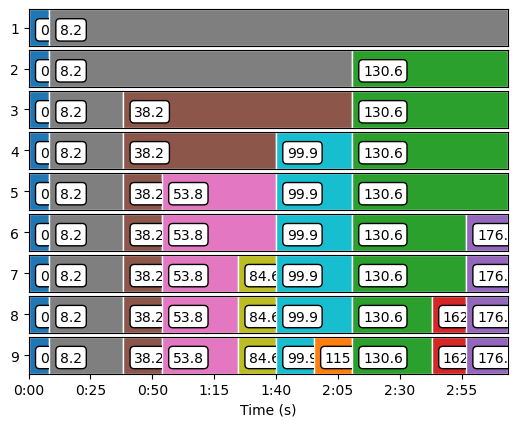

In [388]:
b = bmeasure(refs['6'].itvls, ests['mu5_gamma5'].itvls, window=0.5, beta=1.0, force_mono='bsc')
print('      p, r, f:', '\t'.join([f'{i:.4f}' for i in b]))

## Let's build a d_ref by d_est table, and get all their scores

In [286]:
import xarray as xr

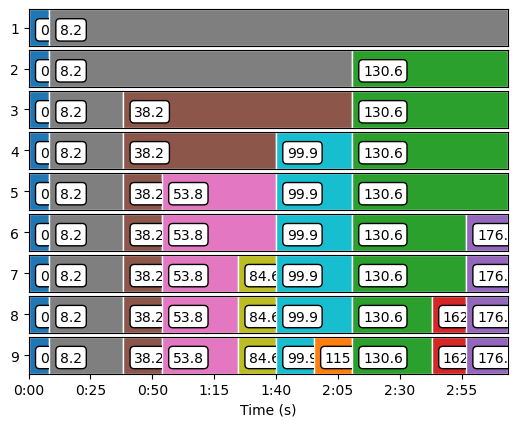

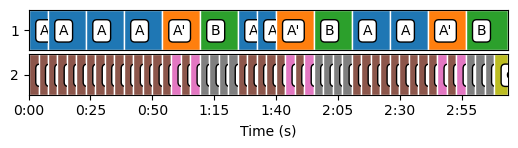

In [264]:
import itertools

coords = dict(d_ref = list(range(ref.d)), d_est = list(range(est.d)), score=['p','r','f'])
ref = refs['6']
est = ests['mu5_gamma5']
# fixed_est = est.force_mono_B(min_seg_dur=1)
fixed_est = est.decode_B(sr=10, bw=1)
fixed_est.plot()
ref.plot()

# Collect results
coords = dict(d_ref = list(range(ref.d)), d_est = list(range(fixed_est.d)), score=['p','r','f'])
result = xr.DataArray(coords=coords, dims=coords.keys())

result = xr.DataArray(coords=coords, dims=coords.keys())
for r_lvl, e_lvl in itertools.product(range(ref.d), range(fixed_est.d)):

    result.loc[dict(d_ref=r_lvl, d_est=e_lvl, score=slice(None))] = np.array(
        mir_eval.segment.detection(ref.itvls[r_lvl], fixed_est.itvls[e_lvl])
    )

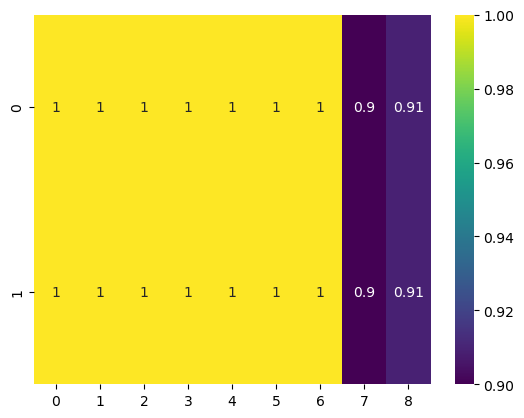

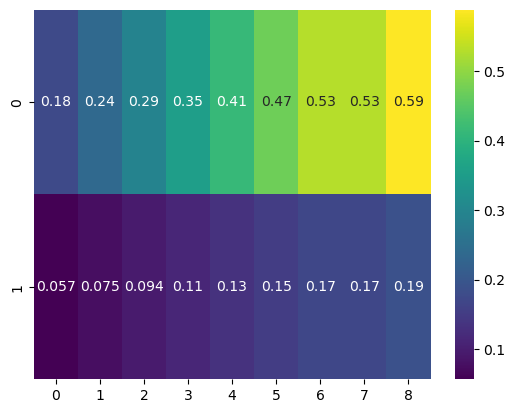

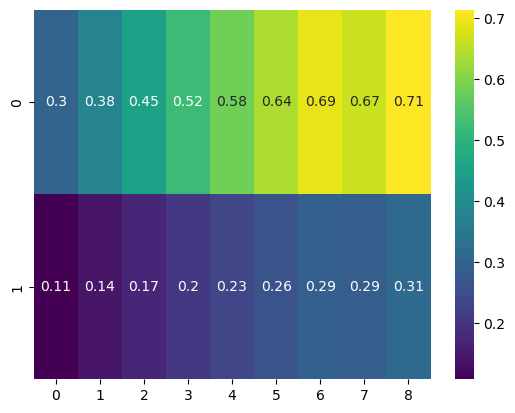

In [265]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Plot using seaborn heatmap.
# Use .values to convert the DataArray slice to a NumPy array.

for s in ['p', 'r', 'f']:
    da_slice = result.sel(score=s)
    sns.heatmap(da_slice.values, annot=True, cmap='viridis',
                xticklabels=da_slice.d_est.values,
                yticklabels=da_slice.d_ref.values)
    plt.show()
    